In [1]:
import numpy as np
from gwbench import network

/home/sreelakshmi/anaconda3/envs/igwn-py310/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## User Choices

#### choose the desired detectors

In [2]:
network_spec = ['aLIGO_H','aLIGO_L','aLIGO_V']

#### initialize the network with the desired detectors

In [3]:
net = network.Network(network_spec)

#### choose the desired waveform 

In [4]:
wf_model_name = 'lal_bbh_jframe'

#### pass the chosen waveform to the network for initialization

In [5]:
net.set_wf_vars(wf_model_name=wf_model_name)

#### pick the desired frequency range

In [6]:
f = np.arange(5.,1024,2**-4)
print(len(f))

16304


#### set the injection parameters

In [7]:
inj_params = {
    'Mc':          27.9,
    'eta':         0.249,
    'a_1':         0.3,
    'a_2':         0.3,
    'tilt_1':      0,
    'tilt_2':      0,
    'phi_12':      0,
    'phi_jl':      0,
    'theta_jn':    0,
    'DL':          470,
    'tc':          0,
    'phic':        0,
    'approximant': 'IMRPhenomXP',
    'ra':          np.pi/4,
    'dec':         np.pi/4,
    'psi':         np.pi/4,
    'gmst0':       0
    }

In [8]:

from gwbench import basic_relations
tot_mass = basic_relations.M_of_Mc_eta(27.9, 0.249)
print(tot_mass)
m1,m2 = basic_relations.m1_m2_of_M_eta(tot_mass,0.249)
print(m1,m2)
k= m1/(m1+m2)
print(k)

64.25169587301812
34.15766496138084 30.09403091163728
0.5316227766016838


In [9]:
deriv_symbs_string = 'Mc eta a_1 DL tc phic'

#### assign which parameters to convert to cos or log versions

In [10]:
#conv_cos = ('dec')
#conv_log = ('Mc','DL')

#### choose whether to take Earth's rotation into account

In [11]:
use_rot = 0

#### pass all these variables to the network

In [12]:
net.set_net_vars(
    f=f, inj_params=inj_params,
    deriv_symbs_string=deriv_symbs_string,
    use_rot=use_rot
    )

## GW benchmarking

#### compute the WF polarizations

In [13]:
net.calc_wf_polarizations()
f0=net.hfc
print(len(f0))
#print(f0)

2023-11-18 11:48:58,774 - Network - INFO : Polarizations calculated.


16304


#### compute the WF polarizations and their derivatives

In [14]:
net.calc_wf_polarizations_derivs_num()
f1=net.del_hfpc
print(len(f1))
#print(f1)

for key in f1.keys():
   print(key)


2023-11-18 11:48:58,837 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-18 11:48:58,880 - Network - INFO : Polarizations calculated.
2023-11-18 11:49:03,626 - Network - INFO : Numeric derivatives of polarizations calculated.


12
del_Mc_hfp
del_Mc_hfc
del_eta_hfp
del_eta_hfc
del_a_1_hfp
del_a_1_hfc
del_DL_hfp
del_DL_hfc
del_tc_hfp
del_tc_hfc
del_phic_hfp
del_phic_hfc


In [15]:
### edited in gwbench for generating waveform using j-frame parameters. 
import numpy as np
f = np.arange(5.,1024,2**-4)
import lal
import lalsimulation as lalsim
from numpy import exp, pi

from gwbench.basic_relations import m1_m2_of_M_eta, M_of_Mc_eta
from gwbench.utils import Mpc, Msun

wf_symbs_string = 'f Mc eta a_1 a_2 tilt_1 tilt_2 phi_12 phi_jl theta_jn DL tc phic approximant'

def hfpc(f, Mc, eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, theta_jn, DL, tc, phic,  approximant, fRef=0., phiRef=0.):
    f_min   = f[0]
    delta_f = f[1] - f[0]
    f_max   = f[-1] + delta_f

    if not fRef: fRef = f_min

    _m1, _m2 = m1_m2_of_M_eta(M_of_Mc_eta(Mc,eta),eta)
    _m1 *= Msun
    _m2 *= Msun
    _DL = DL * Mpc

    approx = lalsim.GetApproximantFromString(approximant)

    if 'IMRPhenomX' in approximant:
        lal_dict = lal.CreateDict()
        lalsim.SimInspiralWaveformParamsInsertPhenomXHMThresholdMband(lal_dict, 0)
    else:
        lal_dict = None
        
    
    iota, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z = lalsim.SimInspiralTransformPrecessingNewInitialConditions(theta_jn, phi_jl, tilt_1, tilt_2, phi_12,a_1, a_2, _m1, _m2, fRef, phiRef)     

    hPlus, hCross = lalsim.SimInspiralChooseFDWaveform(m1=_m1, m2=_m2,
                                   S1x = spin1x, S1y = spin1y, S1z = spin1z,
                                   S2x = spin2x, S2y = spin2y, S2z = spin2z,
                                   distance = _DL, inclination = iota, phiRef = phiRef,
                                   longAscNodes=0., eccentricity=0., meanPerAno = 0.,
                                   deltaF=delta_f, f_min=f_min, f_max=f_max, f_ref=fRef,
                                   LALpars=lal_dict, approximant=approx)

    pf = exp(1j*(2*f*pi*tc - phic))
    i0 = int(round((f_min-hPlus.f0) / delta_f))

    hfp = pf *  hPlus.data.data[i0:i0+len(f)]
    hfc = pf * hCross.data.data[i0:i0+len(f)]
    #params = [iota, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z]
    return hfp

a = hfpc(f, 27.9, 0.249, 0.34, 0.34, np.pi/4, np.pi/4, 0, 0, 0, 470, 0, 0, 'IMRPhenomXP', fRef=0., phiRef=0.)
print(type(a))

<class 'numpy.ndarray'>


In [16]:
# gwbench code for generating the waveform using l-frame parameters
import lal
import lalsimulation as lalsim
from numpy import exp, pi

from gwbench.basic_relations import m1_m2_of_M_eta, M_of_Mc_eta
from gwbench.utils import Mpc, Msun

wf_symbs_string = 'f Mc eta chi1x chi1y chi1z chi2x chi2y chi2z DL tc phic iota approximant'

def hfpc(f, Mc, eta, chi1x, chi1y, chi1z, chi2x, chi2y, chi2z, DL, tc, phic, iota, approximant, fRef=0., phiRef=0.):
    f_min   = f[0]
    delta_f = f[1] - f[0]
    f_max   = f[-1] + delta_f

    if not fRef: fRef = f_min

    _m1, _m2 = m1_m2_of_M_eta(M_of_Mc_eta(Mc,eta),eta)
    _m1 *= Msun
    _m2 *= Msun
    _DL = DL * Mpc

    approx = lalsim.GetApproximantFromString(approximant)

    if 'IMRPhenomX' in approximant:
        lal_dict = lal.CreateDict()
        lalsim.SimInspiralWaveformParamsInsertPhenomXHMThresholdMband(lal_dict, 0)
    else:
        lal_dict = None

    hPlus, hCross = lalsim.SimInspiralChooseFDWaveform(m1=_m1, m2=_m2,
                                   S1x = chi1x, S1y = chi1y, S1z = chi1z,
                                   S2x = chi2x, S2y = chi2y, S2z = chi2z,
                                   distance = _DL, inclination = iota, phiRef = phiRef,
                                   longAscNodes=0., eccentricity=0., meanPerAno = 0.,
                                   deltaF=delta_f, f_min=f_min, f_max=f_max, f_ref=fRef,
                                   LALpars=lal_dict, approximant=approx)

    pf = exp(1j*(2*f*pi*tc - phic))
    i0 = int(round((f_min-hPlus.f0) / delta_f))

    hfp = pf *  hPlus.data.data[i0:i0+len(f)]
    hfc = pf * hCross.data.data[i0:i0+len(f)]

    return hfp

b= hfpc(f, 27.9, 0.249, -1.4721252956003386e-17, 0.24041630560342617, 0.2404163056034262, -1.4721252956003386e-17, 0.24041630560342617, 0.2404163056034262, 470, 0, 0, 0, 'IMRPhenomXP', fRef=0., phiRef=0.) 
print(b)
print(len(b))

[-2.81160092e-22-2.81160092e-22j  1.31843884e-22-3.68707448e-22j
  3.29814834e-22-1.98997210e-22j ...  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
16304


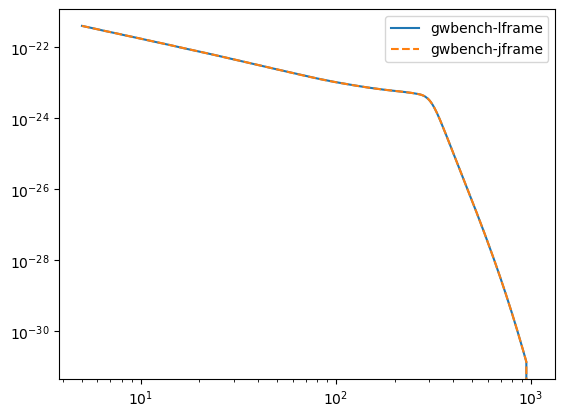

In [17]:
import matplotlib.pyplot as plt
plt.loglog(f,np.abs(b),label= 'gwbench-lframe')
plt.loglog(f,np.abs(a),label= 'gwbench-jframe', linestyle='dashed')
plt.legend()
plt.show()

#### setup antenna patterns, location phase factors, and PSDs

In [18]:
net.setup_ant_pat_lpf_psds()

2023-11-18 11:49:04,991 - Network - INFO : PSDs loaded.
2023-11-18 11:49:04,998 - Network - INFO : Antenna patterns and LPFs loaded.


#### compute the detector responses

In [19]:
net.calc_det_responses()

2023-11-18 11:49:05,179 - Network - INFO : Detector responses calculated.


#### compute the detector responses and their derivatives

In [20]:
net.calc_det_responses_derivs_num()

2023-11-18 11:49:05,217 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-18 11:49:05,228 - Network - INFO :    aLIGO_H
2023-11-18 11:49:07,873 - Network - INFO :    aLIGO_L
2023-11-18 11:49:10,516 - Network - INFO :    aLIGO_V
2023-11-18 11:49:12,910 - Network - INFO : Numeric derivatives of detector responses calculated.


#### calculate the network and detector SNRs

In [21]:
net.calc_snrs()
print(net.detectors[2].snr)

2023-11-18 11:49:12,929 - Network - INFO : SNRs calculated.


83.02197077776998


#### calculate the network and detector Fisher matrices, condition numbers, covariance matrices, error estimates, and inversion errors

In [22]:
net.calc_errors()

2023-11-18 11:49:12,997 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-18 11:49:12,998 - Network - INFO :    aLIGO_H
2023-11-18 11:49:13,055 - Network - INFO :    aLIGO_L
2023-11-18 11:49:13,112 - Network - INFO :    aLIGO_V
2023-11-18 11:49:13,201 - Network - INFO : Errors calculated.


#### calculate the 90%-credible sky area (in deg)

In [23]:
net.calc_sky_area_90()

2023-11-18 11:49:13,214 - Network - WARNING : calc_sky_area_90: tag = network - Nothing done due to missing of either RA or COS_DEC (DEC) errors.


In [24]:
h_ul=net.detectors[2].hf
print(len(h_ul))
A_ul=np.abs(h_ul)
phi_ul= np.angle(h_ul)

16224


In [25]:
f2=net.detectors[2].del_hf
print(len(f2))
#print(f2)
key_list = list(f2.keys()) # returns a list containing the derivatives for each parameter.
print(key_list)
#for i in range(len(key_list)):
#print(f2[key_list[0]])
print(len(f2[key_list[4]]))
a=f2[key_list[2]]
print(a[:10])

6
['del_Mc_hf', 'del_eta_hf', 'del_a_1_hf', 'del_DL_hf', 'del_tc_hf', 'del_phic_hf']
16224
[-8.23181795e-25+2.72050800e-24j  2.00795806e-23-2.01375080e-23j
  1.01975148e-23+5.50327008e-23j -7.77954805e-23-2.86186579e-23j
  8.17009165e-23-7.24013422e-23j  3.58036401e-23+1.29974149e-22j
 -1.57978570e-22-2.43724721e-23j  9.50490415e-23-1.57878013e-22j
  1.29574555e-22+1.62882569e-22j -2.17684496e-22+7.85258413e-23j]


In [26]:
f3=net.detectors[2].fisher
print(f3)

[[ 6.19515173e+05 -7.57051046e+06 -2.05595813e+06 -4.18602662e-01
  -3.30119496e+07  6.47438669e+04]
 [-7.57051046e+06  9.80503640e+07  2.69194797e+07 -1.87737022e+01
   4.89721135e+08 -8.01608647e+05]
 [-2.05595813e+06  2.69194797e+07  7.41773876e+06 -1.88695681e+00
   1.38457615e+08 -2.18730448e+05]
 [-4.18602662e-01 -1.87737022e+01 -1.88695681e+00  3.12012076e-02
   2.54177031e-02 -1.18950712e-05]
 [-3.30119496e+07  4.89721135e+08  1.38457615e+08  2.54177031e-02
   3.25996874e+09 -3.70679253e+06]
 [ 6.47438669e+04 -8.01608647e+05 -2.18730448e+05 -1.18950712e-05
  -3.70679253e+06  6.89264707e+03]]


In [27]:
cov_matrix =net.detectors[2].cov
print(cov_matrix)

[[ 7.4557553e-04  3.2720174e-05  4.7114809e-05  3.2541234e-02
  -3.3528904e-06 -3.5060104e-03]
 [ 3.2720174e-05  1.0479274e-05 -3.2771888e-05  4.7623389e-03
   7.1654989e-09 -1.2474191e-04]
 [ 4.7114809e-05 -3.2771888e-05  1.4466129e-04 -1.0337292e-02
  -9.2909914e-07 -1.6289443e-04]
 [ 3.2541234e-02  4.7623389e-03 -1.0337292e-02  3.4726971e+01
  -9.6872282e-05 -1.3194913e-01]
 [-3.3528904e-06  7.1654989e-09 -9.2909914e-07 -9.6872282e-05
   2.0519133e-08  1.3878690e-05]
 [-3.5060104e-03 -1.2474191e-04 -1.6289443e-04 -1.3194913e-01
   1.3878690e-05  2.0864831e-02]]


In [28]:
for i in np.arange(0,6):
   err= np.sqrt(cov_matrix[i,i])
   print(err)
                


0.027305229
0.0032371706
0.012027523
5.8929596
0.00014324501
0.14444664


In [29]:
from gwbench import fisher_analysis_tools
n=fisher_analysis_tools.calc_cond_number(f3)
print(n)

116003299299.99388


In [30]:
v = 0.34
w = v**2
print(1/w)

8.650519031141867


In [31]:
n = 6
prior_matrix = np.zeros((n, n), dtype=float)
#prior_matrix[2,2] = 10000
#prior_matrix[3,3] = 1/(np.pi/4)**2,
prior_matrix[5,5] = 1/(np.pi**2)
#print(prior_matrix)
prior_fisher = f3 + prior_matrix
print(prior_fisher)

[[ 6.19515173e+05 -7.57051046e+06 -2.05595813e+06 -4.18602662e-01
  -3.30119496e+07  6.47438669e+04]
 [-7.57051046e+06  9.80503640e+07  2.69194797e+07 -1.87737022e+01
   4.89721135e+08 -8.01608647e+05]
 [-2.05595813e+06  2.69194797e+07  7.41773876e+06 -1.88695681e+00
   1.38457615e+08 -2.18730448e+05]
 [-4.18602662e-01 -1.87737022e+01 -1.88695681e+00  3.12012076e-02
   2.54177031e-02 -1.18950712e-05]
 [-3.30119496e+07  4.89721135e+08  1.38457615e+08  2.54177031e-02
   3.25996874e+09 -3.70679253e+06]
 [ 6.47438669e+04 -8.01608647e+05 -2.18730448e+05 -1.18950712e-05
  -3.70679253e+06  6.89274839e+03]]


In [32]:
def invertSVD(matrix):
    '''
    Adapted from GWFish
    '''
    thresh = 1e-10

    dm = np.sqrt(np.diag(matrix))
    normalizer = np.outer(dm, dm)
    matrix_norm = matrix / normalizer

    [U, S, Vh] = np.linalg.svd(matrix_norm)

    kVal = sum(S > thresh)
    matrix_inverse_norm = U[:, 0:kVal] @ np.diag(1. / S[0:kVal]) @ Vh[0:kVal, :]

    # print(matrix @ (matrix_inverse_norm / normalizer))

    return matrix_inverse_norm / normalizer, S

In [33]:
new_cov = invertSVD(prior_fisher)

In [34]:
print(new_cov[0])

[[ 7.44332681e-04  3.26759558e-05  4.70570640e-05  3.24944614e-02
  -3.34797056e-06 -3.49861407e-03]
 [ 3.26759558e-05  1.04777014e-05 -3.27739419e-05  4.76067494e-03
   7.34054161e-09 -1.24478766e-04]
 [ 4.70570640e-05 -3.27739419e-05  1.44658599e-04 -1.03394655e-02
  -9.28870540e-07 -1.62550796e-04]
 [ 3.24944614e-02  4.76067494e-03 -1.03394655e-02  3.47252114e+01
  -9.66871281e-05 -1.31670773e-01]
 [-3.34797056e-06  7.34054161e-09 -9.28870540e-07 -9.66871281e-05
   2.04996576e-08  1.38494115e-05]
 [-3.49861407e-03 -1.24478766e-04 -1.62550796e-04 -1.31670773e-01
   1.38494115e-05  2.08208143e-02]]


In [35]:
from gwbench import fisher_analysis_tools
n=fisher_analysis_tools.calc_cond_number(f3)
print(n)

116003299299.99388


In [36]:
for i in np.arange(0,6):
   err= np.sqrt(new_cov[0][i,i])
   print(err)
### due to sufficiently high SNR ,gaussian priors does not have a significant effect  

0.02728246105362757
0.0032369277644520075
0.012027410327338863
5.892810140930428
0.00014317701492309865
0.144294193680793


#### calculation of systematic errors

In [37]:
from gwbench.wf_models import py_lgw
lgw = py_lgw.lensed_wf_gen()
x = (1e1, 5e1, 1e2, 5e2, 1e3, 5e3, 1e4, 5e4, 1e5)
y = (0.01, 0.05, 0.1, 0.5, 1.0, 3.0, 5.0)
chirp_time = lgw.tchirp_2PN(64.25, 0.249, f_low=10) # returns the chirptime given the total mass,eta and low frequency cut off.
#print(chirp_time)
ml_y_pairs = []
for i in x:
    for j in y:
        time_delay= lgw.td_point_sec(i, j, zl=0)
        if time_delay < chirp_time:
            pairs = (i,j)
            ml_y_pairs.append(pairs)

print(len(ml_y_pairs))  

59


In [38]:
delta_h_list=[]
for i,j in  ml_y_pairs:
        fs = net.detectors[2].f # returns the truncated frequency array tto the range dictated by the given detector’s PSD
        ws = lgw.w_of_f(fs, ml=i) #Converts a dimensionful frequency (f) to the dimensionless frequency (w)
        Fws = lgw.point_Fw_eff_map(ws,j) # returns an array containing amplification factors
    
        #calculation of  amplitude differences and (A_l-A_ul) and Phase differences using the analytical formula.
        R = np.abs(Fws)
        phi = np.angle(Fws)
        delta_A = A_ul*(R-1)
        delta_phi = phi

        # calculation of deta_h (h_l-h_ul) (reference - Eq.30 arXiv:0707.2982)
        delta_h = (delta_A + 1j*A_ul*delta_phi)*np.exp(1j*phi_ul)
        delta_h_list.append(delta_h)

print(len(delta_h_list))

59


In [39]:
import gwbench.snr as snr_mod
inner_product_list=[]
for j in range(len(delta_h_list)):
    for i in range(len(key_list)):
         inner_product = snr_mod.scalar_product_freq_array(delta_h_list[j], f2[key_list[i]], net.detectors[2].psd, fs)
         inner_product_list.append(inner_product)
print(len(inner_product_list))

354


In [40]:
inner_list_length = 6
sep_inner_product = [inner_product_list[i:i + inner_list_length] for i in range(0, len(inner_product_list), inner_list_length)]
print(len(sep_inner_product))
print(sep_inner_product[0])

59
[10257.550832205028, -142101.27249290637, -40046.79644917145, -1.2428307160166474, -857319.467247815, 1122.1322738677738]


In [48]:
delta_p_list=[]

for i in range (len(sep_inner_product)):
    error =0
    for j in range (0,6):
      
           error += new_cov[0][3,j]* sep_inner_product[i][j]
    delta_p_list.append(error)

print(len(delta_p_list))
abs_err=np.abs(delta_p_list)/470
print(abs_err)

59
[7.90207146e-02 7.90102525e-02 7.89775595e-02 7.79322798e-02
 7.46791858e-02 4.30154135e-02 1.02174682e-02 3.99601599e-01
 3.99195323e-01 3.97926705e-01 3.58169347e-01 2.47100012e-01
 1.17149698e-02 2.08749438e-03 7.65221471e-01 7.62998128e-01
 7.56072096e-01 5.52746494e-01 2.25840528e-01 2.62132369e-04
 3.48721689e-04 2.69146651e+00 2.57060560e+00 2.22194303e+00
 4.52192152e-01 1.06066685e-01 7.65445700e-03 1.19381352e-03
 4.19335304e+00 3.55093218e+00 2.37260682e+00 3.59524713e-01
 1.08245784e-01 6.16990138e-03 9.23693055e-04 9.17553040e+00
 3.35046766e+00 1.78822822e+00 3.86028335e-01 1.22388216e-01
 6.40459139e-03 1.02374156e-03 9.68975309e+00 2.91267471e+00
 1.82010569e+00 3.83647985e-01 1.21864898e-01 6.28550853e-03
 1.03619223e-03 7.68599792e+00 3.04591462e+00 1.86755902e+00
 3.82163283e-01 1.21778384e-01 7.90626655e+00 3.03948262e+00
 1.86523383e+00 3.82019580e-01 1.21936735e-01]


In [49]:
samples= np.column_stack(ml_y_pairs).T
masses =np.array(samples[:,0])
y= np.array(samples[:, 1])
err=np.array(abs_err)
indices = np.where(abs_err>0.6)
ml_check = masses[indices]
y_check = y[indices]
err_check = err[indices]
print(len(ml_check))
print(ml_check)
print(y_check)
print(err_check)

21
[   100.    100.    100.    500.    500.    500.   1000.   1000.   1000.
   5000.   5000.   5000.  10000.  10000.  10000.  50000.  50000.  50000.
 100000. 100000. 100000.]
[0.01 0.05 0.1  0.01 0.05 0.1  0.01 0.05 0.1  0.01 0.05 0.1  0.01 0.05
 0.1  0.01 0.05 0.1  0.01 0.05 0.1 ]
[0.76522147 0.76299813 0.7560721  2.69146651 2.5706056  2.22194303
 4.19335304 3.55093218 2.37260682 9.1755304  3.35046766 1.78822822
 9.68975309 2.91267471 1.82010569 7.68599792 3.04591462 1.86755902
 7.90626655 3.03948262 1.86523383]


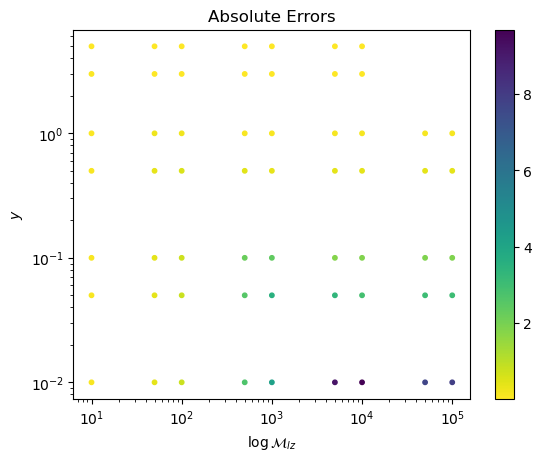

In [50]:
import matplotlib.pyplot as plt

map = plt.cm.get_cmap('viridis')
reversed_map= map.reversed(map) 
plot = plt.scatter(samples[:, 0], samples[:, 1], c=abs_err, cmap=reversed_map,  s=10)
plt.xlabel(r'$\log \mathcal{M}_{lz}$')
plt.ylabel(r'$y$')
plt.xscale('log')
plt.yscale('log')
# ticks_list = []
cbar = plt.colorbar(plot)
# cbar.set_ticklabels(list(map(str, ticks_list)))
plt.title('Absolute Errors')
plt.savefig('Abs_Errors in eta.png',dpi=300, bbox_inches='tight')
plt.show()

In [44]:
fs = net.detectors[0].f # returns the truncated frequency array tto the range dictated by the given detector’s PSD
ws = lgw.w_of_f(fs, ml=10000) #Converts a dimensionful frequency (f) to the dimensionless frequency (w)
Fws = lgw.point_Fw_eff_map(ws,0.01)
h_l = h_ul*Fws
#print(len(h_l))
snr_ul=snr_mod.snr_freq_array(h_ul,net.detectors[0].psd,fs)
snr_l =snr_mod.snr_freq_array(h_l,net.detectors[0].psd,fs)
print(snr_l/snr_ul)

11.21007022487382
